In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import pandas as pd

In [2]:
# physical paarameters
lambda_x_ray = 1.54055                  # x-raywavelength
h_beamwidth   = 0.5                       # beamwidth: Use value of s1hg (mm)
l_waferlength = 25                        # sample length in beam direction (mm)
d_film      = 0.000007                  # approx. thickness of lipid film: 7 microns
abs_coeff   = 783                       # absorption coefficient of lipid film (m^-1)
peakwidth   = 40                        # half width of interval for peak search (points)

In [3]:
RH92_data = np.loadtxt(f"data/RH_data/RH92.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH90_data = np.loadtxt(f"data/RH_data/RH90.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH88_data = np.loadtxt(f"data/RH_data/RH88.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH86_data = np.loadtxt(f"data/RH_data/RH86.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH84_data = np.loadtxt(f"data/RH_data/RH84.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH82_data = np.loadtxt(f"data/RH_data/RH82.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH80_data = np.loadtxt(f"data/RH_data/RH80.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH78_data = np.loadtxt(f"data/RH_data/RH78.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH76_data = np.loadtxt(f"data/RH_data/RH76.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH74_data = np.loadtxt(f"data/RH_data/RH74.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH72_data = np.loadtxt(f"data/RH_data/RH72.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH70_data = np.loadtxt(f"data/RH_data/RH70.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH68_data = np.loadtxt(f"data/RH_data/RH68.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH66_data = np.loadtxt(f"data/RH_data/RH66.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH64_data = np.loadtxt(f"data/RH_data/RH64.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH62_data = np.loadtxt(f"data/RH_data/RH62.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
RH60_data = np.loadtxt(f"data/RH_data/RH60.txt", delimiter = " ", skiprows = 1, usecols = [0,3])

In [4]:
# +++++ READING IN DATA +++++

RH_data_dict = {}
# iterate through the RH values (hope those are the correct ones)
# for RH in range(60, 93, 2):
for RH in range(60, 93, 2):
    RH_data = np.loadtxt(f"data/RH_data/RH{RH}.txt", delimiter = " ", skiprows = 1, usecols = [0,3])
    RH_data_dict[f"RH{RH}"] = {}
    # each dictionary entry includes another dictionary with tth "angle", "q_z", and reflectivity "R" as entries
    RH_data_dict[f"RH{RH}"]["angle"] = RH_data[1:,0]
    RH_data_dict[f"RH{RH}"]["q_z"] = 4*np.pi / lambda_x_ray * np.sin(RH_data[1:,0] / 360 * 2 * np.pi)
    RH_data_dict[f"RH{RH}"]["R"] = RH_data[1:,1]



# +++++ APPLY CORRECTIONS +++++

# apply illumination correction
q_z_c = 4*np.pi / lambda_x_ray * h_beamwidth / l_waferlength                                                 # critical value q_z_c > q_z where the illumination correction has to be applied

# iterate through the RH values
for key in RH_data_dict:
    R_array = RH_data_dict[key]["R"]                    # RH specific R array
    R_corr_array = np.zeros_like(R_array)               # additional array for the corrected reflectivities
    q_z_array = RH_data_dict[key]["q_z"]                # RH specific q_z array
    len_R_array = len(R_array)                          # length of the arrays in the RH value dict
    # iterate through the array indices (leaving out index 0 due to 0 division, not affected by illumination correction anyway)
    for i in range(len_R_array):
        q_z = q_z_array[i]
        # illumination correction: check for "incomplete" reflection
        if q_z < q_z_c:
            R_corr_array[i] = R_array[i] * q_z_c / q_z                   # multiply with the correction factor (> 1)
        else:
            R_corr_array[i] = R_array[i]
    
    # add corrected reflectivity to the correct dictionary entry
    RH_data_dict[key]["R_corr"] = R_corr_array


# apply polarization correction (interaction of E-field of radiation varies for different angles)

# iterate through the RH values
for key in RH_data_dict:
    R_corr_array = RH_data_dict[key]["R_corr"]          # additional array for the corrected reflectivities
    angle_array = RH_data_dict[key]["angle"]            # RH specific angle array
    len_R_corr_array = len(R_corr_array)                # length of the arrays in the RH value dict
    # iterate through the array indices
    for i in range(len_R_corr_array):
        angle_d = angle_array[i] / 360 * 2 * np.pi        # angle (in rad)
        corr_pol = (1 + np.cos(2*angle_d)**2) / 2         # correction factor
        R_corr_array[i] /= corr_pol                        # correct R_corr by the polarization correction factor


# apply absorption correction (the sample absorbs radiation)

# iterate through the RH values
for key in RH_data_dict:
    R_corr_array = RH_data_dict[key]["R_corr"]          # additional array for the corrected reflectivities
    angle_array = RH_data_dict[key]["angle"]            # RH specific angle array
    len_R_corr_array = len(R_corr_array)                # length of the arrays in the RH value dict
    # iterate through the array indices (leaving out 0 index because of 0 division: )
    for i in range(len_R_corr_array):
        angle_d = angle_array[i]  / 360 * 2 * np.pi       # angle (in rad)       
        corr_abs = (1 - np.exp(-1*2*d_film*abs_coeff / np.sin(angle_d))) / (2*d_film*abs_coeff / np.sin(angle_d))
        R_corr_array[i] /= corr_abs                        # correct R_corr by the polarization correction factor


RH_data_dict.keys()
RH_data_dict["RH60"]["R"][:5], RH_data_dict["RH62"]["R"][:5]

(array([52774800., 53160900., 48477000., 38118600., 24948300.]),
 array([52700700., 54030600., 48375600., 38493000., 25112100.]))

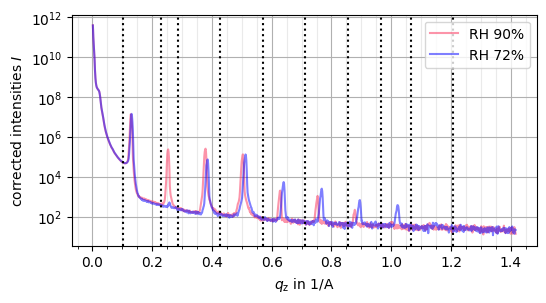

In [5]:
# plotting data (sanity check)
RH = 90
RH_R_corr = RH_data_dict[f"RH{RH}"]["R_corr"]
RH_angle = RH_data_dict[f"RH{RH}"]["angle"]
RH_q_z = RH_data_dict[f"RH{RH}"]["q_z"]

RH_2 = 72
RH_3 = 62


fig, ax = plt.subplots(figsize=(6,3))
ax.set_xlabel(r'$q_\mathrm{z}$ in 1/A')             # \mathrm{\AA} wird im notebook angezeigt aber nicht im pgf plot!! dazu durch \si{\AA} in der .pgf ersetzen!!
ax.set_ylabel(r'corrected intensities $I$')      
ax.grid()
ax.grid(which='minor', color = '#999999', alpha = 0.2, linestyle = '-')
ax.minorticks_on()

ax.semilogy(RH_q_z, RH_R_corr, color = "xkcd:red pink", alpha = 0.5, label = f"RH {RH}%")
ax.semilogy(RH_data_dict[f"RH{RH_2}"]["q_z"], RH_data_dict[f"RH{RH_2}"]["R_corr"], color = "blue", alpha = 0.5, label = f"RH {RH_2}%")
# ax.semilogy(RH_data_dict[f"RH{RH_3}"]["q_z"], RH_data_dict[f"RH{RH_3}"]["R_corr"], color = "black", alpha = 0.5, label = f"RH {RH_3}%")


# indizes for vertical marks for period D determination
q_z_index_list = [70, 160, 200, 300, 400, 500, 600, 680, 750, 850]

# plot xvlines 
for q_z_index in q_z_index_list:
    q_z = RH_q_z[q_z_index]
    ax.axvline(x = q_z, linestyle = "dotted", color = "black")

ax.legend()
ax.legend(loc="upper right")

plt.savefig('BK.SLM_visualizations/corr_R_over_q_z.pdf', facecolor = 'white', bbox_inches='tight')
plt.savefig('BK.SLM_visualizations/corr_R_over_q_z.pgf', facecolor = 'white', bbox_inches='tight')
plt.show()

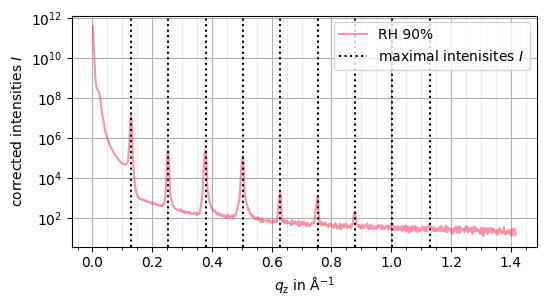

In [6]:
# +++++ DETERMINATION OF MAXIMA +++++

# function to return (max_value_index, max_value) for a given array and start, end index
def get_max(array, start_i, end_i):
    max_index = start_i
    max_value = array[start_i]
    for i in range(start_i, end_i):
        if array[i] > max_value:
            max_index = i
            max_value = array[i]
    return (max_index, max_value)


# iterate through the RH values
for key in RH_data_dict:
    RH_R_corr = RH_data_dict[key]["R_corr"]
    q_z_array = RH_data_dict[key]["q_z"]

    # iterate through the q_z index checkmarks
    max_q_z_list = []
    max_q_z_index_list = []
    for i in range(1, len(q_z_index_list)):
        q_z_start_index = q_z_index_list[i-1]
        q_z_end_index = q_z_index_list[i]

        max_q_z_index, max_value = get_max(RH_R_corr, q_z_start_index, q_z_end_index)
        max_q_z_list.append(q_z_array[max_q_z_index])
        max_q_z_index_list.append(max_q_z_index)
    
    # save list of indices, and q_z_values of maximum peak values
    RH_data_dict[key]["q_z_max"] = max_q_z_list                     # adds the list of Bragg peak q_z values to respective RH
    RH_data_dict[key]["q_z_index_max"] = max_q_z_index_list         # adds the list of Bragg peak q_z indices to respective RH


# sanity check for maximum determination
RH = 90
RH_R_corr = RH_data_dict[f"RH{RH}"]["R_corr"]
RH_angle = RH_data_dict[f"RH{RH}"]["angle"]
RH_q_z = RH_data_dict[f"RH{RH}"]["q_z"]
RH_max_q_z_list = RH_data_dict[f"RH{RH}"]["q_z_max"]


fig, ax = plt.subplots(figsize=(6,3))
ax.set_xlabel(r'$q_\mathrm{z}$ in $\mathrm{\AA}^{-1}$')             # \mathrm{\AA} wird im notebook angezeigt aber nicht im pgf plot!! dazu durch \si{\AA} in der .pgf ersetzen!!
ax.set_ylabel(r'corrected intensities $I$')      
ax.grid()
ax.grid(which='minor', color = '#999999', alpha = 0.2, linestyle = '-')
ax.minorticks_on()

ax.semilogy(RH_q_z, RH_R_corr, color = "xkcd:red pink", alpha = 0.5, label = f"RH {RH}%")

# plot xvlines at maxima
ax.axvline(x = RH_max_q_z_list[0], linestyle = "dotted", color = "black", label = r"maximal intenisites $I$")
for max_q_z in RH_max_q_z_list[1:]:
    ax.axvline(x = max_q_z, linestyle = "dotted", color = "black")

ax.legend()
ax.legend(loc="upper right")

plt.savefig('BK.SLM_visualizations/corr_R_over_q_z_q_z_max.pdf', facecolor = 'white', bbox_inches='tight')
plt.savefig('BK.SLM_visualizations/corr_R_over_q_z_q_z_max.pgf', facecolor = 'white', bbox_inches='tight')
plt.show()

In [7]:
# dropping shitty q_z maxima from the corresponding lists

# index 9 dropped from RH92
RH_data_dict[f"RH92"]["q_z_max"] = RH_data_dict[f"RH92"]["q_z_max"][:8]
RH_data_dict[f"RH92"]["q_z_index_max"] = RH_data_dict[f"RH92"]["q_z_index_max"][:8]
RH_data_dict[f"RH92"]["q_z_max"]


[0.12812565038309592,
 0.25195072959826637,
 0.37571771892849115,
 0.4993980825954388,
 0.6243828142920381,
 0.7478025893433815,
 0.8724654739236156,
 1.0280012221952777]

In [8]:
# +++++ DETERMINATION OF PERIOD LENGTH +++++

# calculates period D for given q_z
def get_D(q_z, n):
    return 2 * np.pi * n / q_z


# iterate through the RH values
for key in RH_data_dict:
    q_z_max_list = RH_data_dict[key]["q_z_max"]             # list of q_z maxima
    len_q_z_max_list = len(q_z_max_list)                    # len of the q_u maxima list
    D_list = []                                             # list of period lengths D (to be filled)
    # iterate through the maxima (excluding 1st and last)
    for i in range(1, len_q_z_max_list-1):
        q_z = q_z_max_list[i]
        D = get_D(q_z, i+1)                                 # calculate period length for each (maximum) q_z
        D_list.append(D)                                    # append D to D list
    RH_data_dict[key]["D_list"] = D_list
    RH_data_dict[key]["D"] = np.mean(D_list)
    print(f"{key} D: mean: {np.mean(D_list)}, std: {np.std(D_list)},  {D_list}")

RH60 D: mean: 48.82075562154814, std: 0.15834946342402148,  [48.50651574872953, 48.6949500758583, 48.79876516712504, 48.87092586034388, 48.929222058217384, 48.98131517596409, 48.963595264598744]
RH62 D: mean: 48.82075562154814, std: 0.15834946342402148,  [48.50651574872953, 48.6949500758583, 48.79876516712504, 48.87092586034388, 48.929222058217384, 48.98131517596409, 48.963595264598744]
RH64 D: mean: 48.90365762416322, std: 0.16937655875427376,  [48.50651574872953, 48.87450148151844, 48.933762135700476, 48.97906247736787, 49.0193945562798, 48.98131517596409, 49.03105179358236]
RH66 D: mean: 48.96263707162222, std: 0.10367886331618498,  [48.77441765424902, 48.87450148151844, 48.933762135700476, 48.97906247736787, 49.0193945562798, 49.05862525153538, 49.09869594470448]
RH68 D: mean: 48.9723274366228, std: 0.11810861960532808,  [48.77441765424902, 48.87450148151844, 48.933762135700476, 48.97906247736787, 49.0193945562798, 49.05862525153538, 49.166528499708605]
RH70 D: mean: 49.01185325121

In [9]:
# +++++ DETERMINATION OF FORM FACTOR SQUARE VALUES +++++

# function to calculate the integrated value below a given peak
def get_integrated_peak(R_corr_array, q_z_array, peak_i):
    num_intervals = 1                       # number of values summed up
    total_integral_sum = R_corr_array[peak_i]

    # sum values left of peak until turning point is reached
    d_i = 1
    while R_corr_array[peak_i - (d_i-1)] > R_corr_array[peak_i - d_i] or d_i < 5:
        # add values left and right of peak
        total_integral_sum += R_corr_array[peak_i - d_i] + R_corr_array[peak_i + d_i]
        num_intervals += 2
        d_i += 1

    # lower and upper q_z boundaries
    upper_q_z = q_z_array[peak_i + d_i]
    lower_q_z = q_z_array[peak_i - d_i]
    q_z_interval = upper_q_z - lower_q_z
    # lower and upper R values
    upper_R_corr = R_corr_array[peak_i + d_i]
    lower_R_corr = R_corr_array[peak_i - d_i]
    mid_R_corr = (upper_R_corr + lower_R_corr) / 2

    # total integral
    total_integral_sum *= q_z_interval / num_intervals
    # trapezoid subtraction value
    trapezoid_subtraction = mid_R_corr * q_z_interval


    # # sanity check
    # fig, ax = plt.subplots(figsize=(6,3))
    # ax.set_xlabel(r'$q_\mathrm{z}$ in $\mathrm{\AA}^{-1}$')              # \mathrm{\AA} wird im notebook angezeigt aber nicht im pgf plot!! dazu durch \si{\AA} in der .pgf ersetzen!!
    # ax.set_ylabel(r'corrected intensities $I$')      
    # ax.grid()
    # ax.grid(which='minor', color = '#999999', alpha = 0.2, linestyle = '-')
    # ax.minorticks_on()

    # ax.semilogy(RH_q_z, RH_R_corr, color = "xkcd:red pink", alpha = 0.5, label = f"RH {RH}%")

    # # plot xvlines at integration boundaries
    # ax.axvline(x = lower_q_z, linestyle = "dashed", color = "black", linewidth = 1, label = "integration boundaries")
    # ax.axvline(x = upper_q_z, linestyle = "dashed", color = "black", linewidth = 1)

    # # polygon for substracion
    # polygon = Polygon(np.array([ [lower_q_z, 0], [lower_q_z, lower_R_corr], [upper_q_z, upper_R_corr], [upper_q_z, 0] ]), facecolor = "grey", label = "substracted trapezoid")
    # ax.add_patch(polygon)

    # ax.legend()
    # ax.legend(loc="upper right")

    # plt.savefig('BK.SLM_visualizations/corr_R_over_q_z_integrated_peak.pdf', facecolor = 'white', bbox_inches='tight')
    # plt.savefig('BK.SLM_visualizations/corr_R_over_q_z_integrated_peak.pgf', facecolor = 'white', bbox_inches='tight')
    # plt.show()

    return total_integral_sum - trapezoid_subtraction


# # call the sanity check
# RH_R_corr = RH_data_dict["RH60"]["R_corr"]
# q_z_array = RH_data_dict["RH60"]["q_z"]
# max_q_z_index_list = RH_data_dict["RH60"]["q_z_index_max"]

# get_integrated_peak(RH_R_corr, q_z_array, max_q_z_index_list[3])#, get_integrated_peak(RH_R_corr, q_z_array, max_q_z_index_list[4])


# iterate through the RH values
for key in RH_data_dict:
    R_corr_array = RH_data_dict[key]["R_corr"]
    q_z_array = RH_data_dict[key]["q_z"]
    max_q_z_index_list = RH_data_dict[key]["q_z_index_max"]
    D = RH_data_dict[key]["D"]
    form_factor_abs_list = []
    # iterate through all maxima
    for n, max_q_z_index in enumerate(max_q_z_index_list):
        integrated_peak = get_integrated_peak(R_corr_array, q_z_array, max_q_z_index)
        # calculate the absolute value for the form factor (order proportionality included)
        if integrated_peak < 0:
            form_factor_abs_list.append(0)
        else:
            form_factor_abs = np.sqrt(integrated_peak * (n+1)**2)
            # print(integrated_peak)
            form_factor_abs_list.append(form_factor_abs)
    # squared sum of all form factor amplitudes for normalization
    abs_F_q_z_n_normalization_squared_sum = sum([ff_abs**2 for ff_abs in form_factor_abs_list])
    RH_data_dict[key]["abs_F_q_z_n_normalization_squared_sum"] = abs_F_q_z_n_normalization_squared_sum
    # normalize form factor amplitudes to be proportional to period length D
    abs_F_q_z_n = [ff_abs * np.sqrt(D / abs_F_q_z_n_normalization_squared_sum) for ff_abs in form_factor_abs_list]
    RH_data_dict[key]["abs_F_q_z_n"] = abs_F_q_z_n
    # print(f"{key} |F(q_z^n)|: {form_factor_square_value_list}, norm_sum: {sum(form_factor_square_value_list)}")

# printing the normalized data (normalization abs_F_q_z_n**2 propto D done previously, here: normalization to 1 as biggest value)
print("\n +++++ NORMALIZED DATA +++++")
for key in RH_data_dict:
    normalized_abs_F_q_z_n_list = [ff_abs / RH_data_dict["RH60"]["abs_F_q_z_n"][0] for ff_abs in RH_data_dict[key]["abs_F_q_z_n"]]
    RH_data_dict[key]["abs_F_q_z_n_normalized"] = normalized_abs_F_q_z_n_list
    print(f"{key} |F(q_z^n)|:", end='')
    for normalized_abs_F_q_z_n in normalized_abs_F_q_z_n_list:
        print(f" & {round(normalized_abs_F_q_z_n, 4)}", end='')
    print(f"   Proportionality-Check: {sum([F_norm**2 for F_norm in normalized_abs_F_q_z_n_list]) / RH_data_dict[key]["D"] * 100}")


 +++++ NORMALIZED DATA +++++
RH60 |F(q_z^n)|: & 1.0 & 0.0922 & 0.1432 & 0.3979 & 0.107 & 0.0912 & 0.0548 & 0.0586 & 0.0194   Proportionality-Check: 2.4864611051754824
RH62 |F(q_z^n)|: & 0.9977 & 0.0777 & 0.1571 & 0.4014 & 0.1066 & 0.0916 & 0.0551 & 0.0591 & 0.0219   Proportionality-Check: 2.4864611051754824
RH64 |F(q_z^n)|: & 0.9961 & 0.0634 & 0.1712 & 0.405 & 0.107 & 0.0908 & 0.0549 & 0.057 & 0.0208   Proportionality-Check: 2.4864611051754832
RH66 |F(q_z^n)|: & 0.9928 & 0.0497 & 0.1851 & 0.4105 & 0.1093 & 0.0914 & 0.0558 & 0.0542 & 0.016   Proportionality-Check: 2.486461105175482
RH68 |F(q_z^n)|: & 0.99 & 0.0345 & 0.1987 & 0.4133 & 0.1079 & 0.0901 & 0.0542 & 0.0542 & 0.0177   Proportionality-Check: 2.486461105175483
RH70 |F(q_z^n)|: & 0.9858 & 0.0178 & 0.2158 & 0.4179 & 0.1088 & 0.0893 & 0.0541 & 0.0485 & 0.0132   Proportionality-Check: 2.4864611051754824
RH72 |F(q_z^n)|: & 0.9821 & 0.0073 & 0.2316 & 0.42 & 0.1073 & 0.0895 & 0.0535 & 0.0488 & 0.0   Proportionality-Check: 2.4864611051

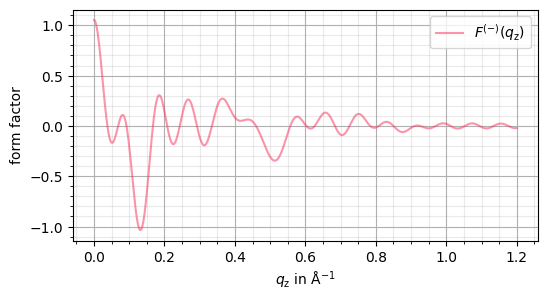

In [26]:
# +++++ CONTINUOUS MINUS FLUID FORM FACTOR +++++

# returns continous minus fluid form factor function for given array with phases
def get_F_minus(phases):
    max_n = 7                                                               # number of fourier segments (we take the frst 7 order form factor amplitudes, 8th one is dropped)

    # continous minus fluid form factor function
    def F_minus_continous(q_z):
        F_minus_q_z_list = []
        # we average over all RH values we got
        for key in RH_data_dict:
            F_q_z_n =  RH_data_dict[key]["abs_F_q_z_n_normalized"]              # normalized form factor amplitudes for current RH
            D = RH_data_dict[key]["D"]                                          # period D for current RH

            F_minus_q_z = 0                                                     # initialization of fourier sum as F^(-)(q_z)
            F_minus_0 = 0                                                       # initialization of the order 0 F^(-)
            # iterate through the form factors until order max_n
            for i in range(max_n):
                nu_i = phases[i]                                                # phase i
                F_i = F_q_z_n[i]                                                # form factor amplitude i
                # calculate form factors for (n = -n_max till n = n_max excluding the order 0 term)
                F_minus_q_z += nu_i * F_i * np.sinc(D/2*q_z - (-i-1)*np.pi) + nu_i * F_i * np.sinc(D/2*q_z - (i+1)*np.pi)
                # calculation the 0-order coefficient (with phase, how amazing is that ?)
                F_minus_0 += 2*(-1)**i * nu_i * F_i
            # add the order 0 term to fourier series
            F_minus_q_z += np.sinc(D/2*q_z)
            # add the newest value to the list
            F_minus_q_z_list.append(F_minus_q_z)
        # return the average value between all RHs
        return sum(F_minus_q_z_list) / len(F_minus_q_z_list)
    return F_minus_continous


# function to check the performance of a given set of phase factors (the lower the better)
def phase_factor_performance(phases):
    return


# list of phases (0-order will be determined from the other phases, genius !!!)
phases_1_list = [-1, 1, 1, -1, 1, 1, -1, 1]
F_minus_func = get_F_minus(phases_1_list)

q_z_conti_array = np.linspace(0, 1.2, 1000)
F_minus_array = np.array([F_minus_func(q_z) for q_z in q_z_conti_array])


fig, ax = plt.subplots(figsize=(6,3))
ax.set_xlabel(r'$q_\mathrm{z}$ in $\mathrm{\AA}^{-1}$')              # \mathrm{\AA} wird im notebook angezeigt aber nicht im pgf plot!! dazu durch \si{\AA} in der .pgf ersetzen!!
ax.set_ylabel(r'form factor')      
ax.grid()
ax.grid(which='minor', color = '#999999', alpha = 0.2, linestyle = '-')
ax.minorticks_on()

ax.plot(q_z_conti_array, F_minus_array, color = "xkcd:red pink", alpha = 0.5, label = r"$F^{(-)}(q_\mathrm{z})$")


ax.legend()
ax.legend(loc="upper right")

plt.savefig('BK.SLM_visualizations/continous_form_factors.pdf', facecolor = 'white', bbox_inches='tight')
plt.savefig('BK.SLM_visualizations/continous_form_factors.pgf', facecolor = 'white', bbox_inches='tight')
plt.show()

In [25]:
# +++++ GENERATE ALL COMBINATIONS OF PHASE FACTORS +++++

# array of all different phase combinations (n = n_max = 8) phase factors
n_max = 8
phase_factor_list = []               # array with all phase factor arrays (i.e. 2**n_max entries)
# iterate through all 2**n_max combinations
for i_factor in range(2**n_max):
    phase_factor_i_array = np.zeros((8))                # array with the 8 phase factors
    # iterate through each 8 phase factor positions
    for i in range(n_max):
        phase_factor_i_array[i] = (int(i_factor / 2**i )  % 2) * 2 - 1
    # add array of phase factors to the total array
    phase_factor_list.append(phase_factor_i_array)
# turn list into array for better performance (probably not needed)
phase_factor_array = np.array([phase_factor_list])


phase_factor_array

array([[[-1., -1., -1., ..., -1., -1., -1.],
        [ 1., -1., -1., ..., -1., -1., -1.],
        [-1.,  1., -1., ..., -1., -1., -1.],
        ...,
        [ 1., -1.,  1., ...,  1.,  1.,  1.],
        [-1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.]]])

In [ ]:
# +++++ e-DENSITY DETERMINATION VIA SWELLING METHOD +++++